# ${\color{pink}\mathbb{NAMES:}}$
1- ${\color{cyan}Yuval\ Kav}$, id: 329

2- ${\color{cyan}Matan\ Gin}$, id: 215

In [2]:
import pandas as pd # knows how to work with tabeles
import numpy as np
import statistics
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV 
from sklearn.svm import SVC,LinearSVC
pd.set_option('display.max_rows', 45)
pd.set_option('display.max_columns', 45)
from sklearn.preprocessing import StandardScaler  # to standardize the features
from sklearn.decomposition import PCA  # to apply PCA
import seaborn as sns
import statistics
from sklearn.neighbors import KNeighborsClassifier

In [3]:
#open file and drop all irrelevent catagories
train = pd.read_csv(r'C:\\Users\\matan\\Documents\\Visual Code thong\\Machinaaaaaaaaa\\The Projecto\\death_prediction_synthetic.csv')
train = train.drop('cancer',axis=1) # all zeros
train = train.drop('residence',axis=1) # residence_cd explains the same thing
train = train.drop('smoking_status',axis=1) # smoking explains the same
train = train.drop('alb24h',axis=1) # not enough data
train = train.drop(['bp_sys','bp_dias'],axis=1) # bp_cat groups both and turns them into a catagory and is very correlated
train['sex'] = train['sex'] - 1 #to make sex be 0 and 1
train['ses'] = train['ses'] - 1 #to make ses be 0 and 1
train['residence_cd'] = train['residence_cd'] - 1 #to make sex be 0 and 1
train['smoking'] = train['smoking'] - 1 #to make sex be 0 and 2
train['marital_status'] = train['marital_status'].map({'U':0,'M':1}).astype(int)
train['bp_cat'] = train['bp_cat'].map({'Normal':0,'Pre-HTN':1,'HTN-G1':2,'HTN-G2':3,'HTN-G3':4}).astype(int)

In [4]:
#fills nulls
for i in range(2):
      
    the_one = train[(train['sex'] == i)]['albumin'].dropna()      
    pip = the_one.mean()
    train['albumin'].loc[(train.albumin.isnull()) & (train['sex']==i)]= pip

    the_one1 = train[(train['sex'] == i)]['ACR'].dropna()      
    pip1 = the_one1.mean()
    train['ACR'].loc[(train.ACR.isnull()) & (train['sex']==i)]= pip1 
  
    the_one2 = train[(train['sex'] == i)]['gravity_u'].dropna()      
    pip2 = the_one2.mean()
    train['gravity_u'].loc[(train.gravity_u.isnull()) & (train['sex']==i)]= pip2
#------------------------------------------------------

for i in range(2): 

    the_one2 = train[(train['sex'] == i)]['nitrites_u'].dropna() 
    pip2 = statistics.mode(the_one2)

    train['nitrites_u'].loc[(train.nitrites_u.isnull()) & (train['sex']==i)]= pip2

    the_one3 = train[(train['sex'] == i)]['leuko_u'].dropna()      
    pip3 = statistics.mode(the_one3) 


    train['leuko_u'].loc[(train.leuko_u.isnull()) & (train['sex']==i)]= pip3

    the_one4 = train[(train['sex'] == i)]['proteinuria'].dropna()      
    pip4 = statistics.mode(the_one4) 
    train['proteinuria'].loc[(train.proteinuria.isnull()) & (train['sex']==i)]= pip4

C:\Users\matan\AppData\Local\Temp\ipykernel_19944\4031511478.py:6: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  train['albumin'].loc[(train.albumin.isnull()) & (train['sex']==i)]= pip
C:\Users\matan\AppData\Local\Temp\ipykernel_19944\403151

In [5]:
#normilize leuko_u
train.loc[(train['leuko_u'] == 25),'leuko_u']=5
train.loc[(train['leuko_u'] == 75),'leuko_u']= 6
train.loc[(train['leuko_u'] == 100),'leuko_u']= 7 
train.loc[(train['leuko_u'] == 250),'leuko_u']=8 
train.loc[(train['leuko_u'] == 500),'leuko_u']=9
train['leuko_u'] = train['leuko_u'].astype(int)

In [6]:
#normilizing floats
for i in train:
    if pd.unique(train[i]).shape[0] > 20:
        mean = train[i].mean()
        teken = statistics.stdev(train[i])
        train[i] = (train[i]-mean)/teken
    

In [7]:
#PCA to correlated variables
corr_matrix = train.corr()
for i in corr_matrix:
    for j in corr_matrix:
        if abs(corr_matrix[i][j])>0.6 and i != j and i != 'sex':
            scalar = StandardScaler()
            train_pair = pd.concat([train[i], train[j]], axis=1)
            pca = PCA(n_components = 1)
            pca.fit(train_pair)
            data_pca = pca.transform(train_pair)
            data_pca = pd.DataFrame(data_pca,columns=[f'{i}+{j}'])
            train = pd.concat([train.drop([i,j],axis=1),data_pca],axis=1)
    corr_matrix=corr_matrix.drop(i,axis=1)
    corr_matrix=corr_matrix.drop(i,axis=0)

In [8]:
#over and under sampling. will be refered to as modified data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import ClusterCentroids
from collections import Counter
X = train.drop('dead_5y',axis=1)
y = train['dead_5y']
print('Original dataset shape %s' % Counter(y))
sm1 = ClusterCentroids(sampling_strategy=0.033)
X_res1, y_res1 = sm1.fit_resample(X, y)
sm2 = SMOTE(random_state=42)
X_res2, y_res2 = sm2.fit_resample(X_res1, y_res1)
print('Resampled dataset shape %s' % Counter(y_res2))
train_fixed = pd.concat([X_res2, y_res2], axis="columns")

Original dataset shape Counter({0: 12241, 1: 197})
Resampled dataset shape Counter({0: 5969, 1: 5969})


In [9]:
#splitting modified data to test train split and extracting the dead
X = train_fixed
X_train, X_test= train_test_split(X, test_size=0.33)

die = X_test.loc[X_test['dead_5y'] == 1]
X_die =  die.drop('dead_5y',axis=1)
y_die = die['dead_5y']

y_train = X_train['dead_5y']
X_train = X_train.drop('dead_5y',axis=1)
y_test = X_test['dead_5y']
X_test = X_test.drop('dead_5y',axis=1)

X = train_fixed.drop('dead_5y',axis=1) #make these for cross validation
y = train_fixed['dead_5y']


# models

In [10]:
#naive gauss model
from sklearn.naive_bayes import GaussianNB
naive=GaussianNB()
naive.fit(X_train,y_train)
acc_naive=round(naive.score(X_test,y_test)*100,2)
print(f"normal score:{acc_naive}")
acc_naive=round(naive.score(X_die,y_die)*100,2)
print(f"dead score:{acc_naive}")

normal score:74.34
dead score:83.61


In [11]:
def find_params_lin(X,y):
    # Define the parameter grid 
        param_grid = {'C': [0.1,0.5,0.3, 1, 2]} 
        
        # Create a grid search object 
        grid = GridSearchCV(LinearSVC(), param_grid, refit=True)
         
        # Fit the grid search object to the training data 
        grid.fit(X, y) 
        
        # Get the best parameters 
        print(grid.best_params_ )
        return grid.best_params_['C']

In [12]:
C = find_params_lin(X,y)

{'C': 0.5}


In [13]:
#linear SVC model
# C = find_params_lin(X,y)
linear_svc=LinearSVC(C=0.3)
linear_svc.fit(X_train,y_train)
acc_linear_svc=round(linear_svc.score(X_test,y_test)*100,2)
print(f"normal score:{acc_linear_svc}")
acc_linear_svc=round(linear_svc.score(X_die,y_die)*100,2)
print(f"dead score:{acc_linear_svc}")

normal score:77.26
dead score:82.18


In [14]:
def find_params(X,y,kernal):
    # Define the parameter grid 
    param_grid = {'C': [0.1, 1, 5], 'gamma': [ 0.1, 0.001,0.0007]} 
        
    # Create a grid search object 
    grid = GridSearchCV(SVC(kernel=kernal), param_grid, refit=True) 
        
    # Fit the grid search object to the training data 
    grid.fit(X, y) 
        
    # Get the best parameters 
    print(grid.best_params_ )
    return grid.best_params_['gamma'], grid.best_params_['C']

In [15]:
gamma, C = find_params(X,y,'rbf')
model = SVC(kernel='rbf',C=C,gamma=gamma)
model.fit(X_train,y_train)

{'C': 5, 'gamma': 0.1}


SVC(C=5, gamma=0.1)

In [16]:
model = SVC(kernel='rbf',C=5,gamma=0.1)
model.fit(X_train,y_train)

SVC(C=5, gamma=0.1)

In [17]:
#rbf model
acc_rbf_svc=round(model.score(X_test,y_test)*100,2)
print(f"normal score:{acc_rbf_svc}")
acc_rbf_svc=round(model.score(X_die,y_die)*100,2)
print(f"dead score:{acc_rbf_svc}")


normal score:99.67
dead score:99.74


normilized and PCA <br>
C = 5 gamma = 0.1 <br> 
normal score : 99.64<br>
dead score : 99.55

normilized no PCA <br>
C = 5 gamma = 0.1 <br>
normal score : 99.8 <br>
dead score : 99.85 

not normilized or PCA'd<br>
C = 5 gamma = 0.001 <br>
normal score : 97.08<br>
dead score : 97.31


In [18]:
def find_params_knn(X,y):
    # Define the parameter grid 
    param_grid = {'n_neighbors': [3,4,5,6]} 
        
    # Create a grid search object 
    grid = GridSearchCV(KNeighborsClassifier(), param_grid, refit=True) 
        
    # Fit the grid search object to the training data 
    grid.fit(X, y) 
        
    # Get the best parameters 
    print(grid.best_params_ )
    return grid.best_params_['n_neighbors']

In [19]:
k= find_params_knn(X,y)

{'n_neighbors': 4}


In [20]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train,y_train)
acc_rbf_svc=round(knn.score(X_test,y_test)*100,2)
print(f"normal score:{acc_rbf_svc}")
acc_rbf_svc=round(knn.score(X_die,y_die)*100,2)
print(f"dead score:{acc_rbf_svc}")

normal score:92.03
dead score:100.0


No PCA <br>
k = 4 <br>
normal score : 92.74<br>
dead score : 100.0

# prototype

In [21]:
train.describe()

,age,sex,marital_status,ses,residence_cd,heigh,bp_cat,smoking,creatinin,albumin,ACR,HDL,triglycerides,TSH,gravity_u,nitrites_u,leuko_u,proteinuria,WBC,RBC,platelets,MCV,MPV,Charlson,framingham_cvd,antidiabetics,ERD,CVD,HTN,cardiovascular_meds,statines,immigrant,dead_5y,weigh+BMI,HbA1c+glucose,cholesterol_total+LDL
count,12438.000000,12438.000000,12438.000000,12438.000000,12438.000000,1.243800e+04,12438.000000,12438.000000,1.243800e+04,1.243800e+04,1.243800e+04,1.243800e+04,1.243800e+04,1.243800e+04,1.243800e+04,12438.000000,12438.000000,12438.000000,1.243800e+04,1.243800e+04,1.243800e+04,1.243800e+04,1.243800e+04,12438.000000,1.243800e+04,12438.000000,12438.000000,12438.000000,12438.000000,12438.000000,12438.000000,12438.000000,12438.000000,1.243800e+04,1.243800e+04,1.243800e+04
mean,43.501126,0.468805,0.686364,0.677279,0.062631,2.111405e-15,0.610388,0.636678,-1.816631e-16,-4.844350e-16,-6.469606e-17,4.992879e-16,1.542423e-17,6.181116e-16,-1.632912e-14,0.030069,1.088197,0.040521,3.416181e-16,-4.044575e-16,4.912902e-17,3.844631e-16,3.541860e-17,1.755427,-2.205093e-16,0.857694,0.006593,0.092057,0.318058,0.602669,0.702203,0.174867,0.015839,-2.170817e-17,-9.425917e-18,-3.998874e-18
std,4.802035,0.499046,0.463989,0.763641,0.242307,1.000000e+00,0.871310,0.871735,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.181290,2.597155,0.197186,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.218773,1.000000e+00,0.349378,0.080931,0.289117,0.465741,0.489365,0.457308,0.379869,0.124856,1.347961e+00,1.329698e+00,1.340012e+00
min,30.000000,0.000000,0.000000,0.000000,0.000000,-7.592292e+00,0.000000,0.000000,-1.495157e+00,-5.851502e+00,-3.464554e-01,-3.041704e+00,-1.154615e+00,-2.189760e+00,-3.031755e+00,0.000000,0.000000,0.000000,-2.976704e+00,-3.780175e+00,-2.954227e+00,-4.665280e+00,-2.961146e+00,0.000000,-1.296683e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.550042e+00,-2.218104e+00,-3.597835e+00
25%,41.000000,0.000000,0.000000,0.000000,0.000000,-7.889766e-01,0.000000,0.000000,-3.526320e-01,-5.076098e-01,-3.107626e-01,-7.091242e-01,-5.575878e-01,-5.479680e-01,-4.487098e-01,0.000000,0.000000,0.000000,-6.734892e-01,-6.844969e-01,-6.763478e-01,-4.752234e-01,-6.728381e-01,1.000000,-7.089740e-01,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-9.400422e-01,-9.290253e-01,-9.544072e-01
50%,45.000000,0.000000,1.000000,0.000000,0.000000,5.571193e-03,0.000000,0.000000,-9.614679e-02,-9.161757e-02,-2.661465e-01,-1.259792e-01,-2.229902e-01,-1.831253e-01,-4.086048e-02,0.000000,0.000000,0.000000,-1.190117e-01,-3.633931e-02,-1.358341e-01,8.762004e-02,-1.388997e-01,1.000000,-2.714008e-01,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,-1.598162e-01,-4.013865e-01,-1.264200e-01
75%,48.000000,1.000000,1.000000,1.000000,0.000000,7.008005e-01,1.000000,2.000000,2.069721e-01,5.483689e-01,-6.033950e-03,5.543565e-01,2.428222e-01,3.033316e-01,3.669888e-01,0.000000,0.000000,0.000000,5.634222e-01,6.118183e-01,5.462428e-01,6.191944e-01,5.475926e-01,2.000000,3.928864e-01,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,7.370365e-01,5.741197e-01,8.098970e-01
max,49.000000,1.000000,1.000000,2.000000,1.000000,3.382399e+00,4.000000,2.000000,2.424663e+01,4.388292e+00,1.298992e+01,9.107148e+00,2.102068e+01,3.350401e+01,3.765733e+00,2.000000,9.000000,1.000000,6.747979e+00,5.506859e+00,6.813628e+00,4.574733e+00,7.336238e+00,14.000000,7.276925e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8.182537e+00,1.038149e+01,6.389681e+00


In [22]:
train.shape

(12438, 36)

In [23]:
corr_matrix = train.corr()
for i in corr_matrix:
    for j in corr_matrix:
        if abs(corr_matrix[i][j])>0.6 and i != j:
            print(f"{i} and {j} are correlated with a pearson parameter of {corr_matrix[i][j]}")
    corr_matrix=corr_matrix.drop(i,axis=1)
    corr_matrix=corr_matrix.drop(i,axis=0)

sex and heigh are correlated with a pearson parameter of -0.707623990873603


In [24]:
corr_matrix = train.corr(method='spearman')
for i in corr_matrix:
    for j in corr_matrix:
        if abs(corr_matrix[i][j])>0.6 and i != j:
            print(f"{i} and {j} are correlated with a pearson parameter of {corr_matrix[i][j]}")
    corr_matrix=corr_matrix.drop(i,axis=1)
    corr_matrix=corr_matrix.drop(i,axis=0)

sex and heigh are correlated with a pearson parameter of -0.7396692016613643
sex and creatinin are correlated with a pearson parameter of -0.6684418025645774


In [25]:
#open file and drop all irrelevent catagories
train = pd.read_csv(r'C:\\Users\\matan\\Documents\\Visual Code thong\\Machinaaaaaaaaa\\The Projecto\\death_prediction_synthetic.csv')
train = train.drop('cancer',axis=1) # all zeros
train = train.drop('residence',axis=1) # residence_cd explains the same thing
train = train.drop('smoking_status',axis=1) # smoking explains the same
train = train.drop('alb24h',axis=1) # not enough data
train = train.drop(['bp_sys','bp_dias'],axis=1) # bp_cat groups both and turns them into a catagory and is very correlated
train['sex'] = train['sex'] - 1 #to make sex be 0 and 1
train['ses'] = train['ses'] - 1 #to make ses be 0 and 1
train['residence_cd'] = train['residence_cd'] - 1 #to make sex be 0 and 1
train['smoking'] = train['smoking'] - 1 #to make sex be 0 and 2
train['marital_status'] = train['marital_status'].map({'U':0,'M':1}).astype(int)
train['bp_cat'] = train['bp_cat'].map({'Normal':0,'Pre-HTN':1,'HTN-G1':2,'HTN-G2':3,'HTN-G3':4}).astype(int)

In [26]:
#fills nulls
for i in range(2):
      
    the_one = train[(train['sex'] == i)]['albumin'].dropna()      
    pip = the_one.mean()
    train['albumin'].loc[(train.albumin.isnull()) & (train['sex']==i)]= pip

    the_one1 = train[(train['sex'] == i)]['ACR'].dropna()      
    pip1 = the_one1.mean()
    train['ACR'].loc[(train.ACR.isnull()) & (train['sex']==i)]= pip1 
  
    the_one2 = train[(train['sex'] == i)]['gravity_u'].dropna()      
    pip2 = the_one2.mean()
    train['gravity_u'].loc[(train.gravity_u.isnull()) & (train['sex']==i)]= pip2
#------------------------------------------------------

for i in range(2): 

    the_one2 = train[(train['sex'] == i)]['nitrites_u'].dropna() 
    pip2 = statistics.mode(the_one2)

    train['nitrites_u'].loc[(train.nitrites_u.isnull()) & (train['sex']==i)]= pip2

    the_one3 = train[(train['sex'] == i)]['leuko_u'].dropna()      
    pip3 = statistics.mode(the_one3) 


    train['leuko_u'].loc[(train.leuko_u.isnull()) & (train['sex']==i)]= pip3

    the_one4 = train[(train['sex'] == i)]['proteinuria'].dropna()      
    pip4 = statistics.mode(the_one4) 
    train['proteinuria'].loc[(train.proteinuria.isnull()) & (train['sex']==i)]= pip4

C:\Users\matan\AppData\Local\Temp\ipykernel_19944\4031511478.py:6: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  train['albumin'].loc[(train.albumin.isnull()) & (train['sex']==i)]= pip
C:\Users\matan\AppData\Local\Temp\ipykernel_19944\403151

In [27]:
#normilize leuko_u
train.loc[(train['leuko_u'] == 25),'leuko_u']=5
train.loc[(train['leuko_u'] == 75),'leuko_u']= 6
train.loc[(train['leuko_u'] == 100),'leuko_u']= 7 
train.loc[(train['leuko_u'] == 250),'leuko_u']=8 
train.loc[(train['leuko_u'] == 500),'leuko_u']=9
train['leuko_u'] = train['leuko_u'].astype(int)

In [28]:
display(train[['weigh+BMI','dead_5y']].groupby(['dead_5y'], as_index=False).mean())
display(train[['HbA1c+glucose','dead_5y']].groupby(['dead_5y'], as_index=False).mean())
display(train[['cholesterol_total+LDL','dead_5y']].groupby(['dead_5y'], as_index=False).mean())

KeyError: "['weigh+BMI'] not in index"

In [286]:
train.head()

,age,sex,marital_status,ses,residence_cd,heigh,bp_cat,smoking,creatinin,albumin,ACR,HDL,triglycerides,TSH,gravity_u,nitrites_u,leuko_u,proteinuria,WBC,RBC,platelets,MCV,MPV,Charlson,framingham_cvd,antidiabetics,ERD,CVD,HTN,cardiovascular_meds,statines,immigrant,dead_5y,weigh+BMI,HbA1c+glucose,cholesterol_total+LDL
0,49,1,0,0,0,160.0,0,0,0.58,3.940000,6.00,39.0,373,12.5,1.025,0.0,0,0.0,10.6,5.11,295,87.9,7.7,1,0.12908,1,0,0,1,1,1,0,0,-0.113431,2.199005,0.691468
1,46,1,1,0,0,152.0,0,0,0.65,4.500000,3.87,41.0,204,13.5,1.021,0.0,0,0.0,8.7,4.45,204,78.1,8.2,1,0.08500,1,0,0,0,1,1,0,0,-1.109705,-0.615917,-1.056911
2,46,1,0,0,0,148.0,1,0,0.59,4.189946,6.35,57.0,272,13.8,1.030,0.0,0,0.0,11.5,5.73,772,85.1,10.2,1,0.10715,1,0,0,1,1,1,0,0,-1.395409,2.108659,0.351540
3,45,0,0,1,0,166.0,0,2,0.70,4.600000,5.00,37.0,84,12.6,1.017,0.0,1,0.0,9.1,5.06,299,84.6,9.1,1,0.10110,1,0,0,0,0,1,0,0,-1.133801,0.263934,-0.867146
4,49,1,0,0,0,161.0,0,0,0.75,4.400000,0.48,57.0,140,11.9,1.028,0.0,0,0.0,6.1,4.64,181,89.8,8.9,1,0.03950,1,0,0,0,0,1,0,0,-2.600306,0.388413,-0.302511


In [287]:
#over and under sampling. will be refered to as modified data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import ClusterCentroids
from collections import Counter
X = train.drop('dead_5y',axis=1)
y = train['dead_5y']
print('Original dataset shape %s' % Counter(y))
sm1 = ClusterCentroids(sampling_strategy=0.033)
X_res1, y_res1 = sm1.fit_resample(X, y)
sm2 = SMOTE(random_state=42)
X_res2, y_res2 = sm2.fit_resample(X_res1, y_res1)
print('Resampled dataset shape %s' % Counter(y_res2))
train_fixed = pd.concat([X_res2, y_res2], axis="columns")

Original dataset shape Counter({0: 8230, 1: 103})
Resampled dataset shape Counter({0: 3121, 1: 3121})


In [288]:
#extracting dead from original data
die = train.loc[train['dead_5y'] == 1]
X_die_real =  die.drop('dead_5y',axis=1)
y_die_real = die['dead_5y']
X_real =  train.drop('dead_5y',axis=1)
y_real = train['dead_5y']

In [289]:
#splitting modified data to test train split and extracting the dead
X = train_fixed
X_train, X_test= train_test_split(X, test_size=0.33)

die = X_test.loc[X_test['dead_5y'] == 1]
X_die =  die.drop('dead_5y',axis=1)
y_die = die['dead_5y']

y_train = X_train['dead_5y']
X_train = X_train.drop('dead_5y',axis=1)
y_test = X_test['dead_5y']
X_test = X_test.drop('dead_5y',axis=1)

X = train_fixed.drop('dead_5y',axis=1) #make these for cross validation
y = train_fixed['dead_5y']


In [172]:
#linear SVC model
# C = find_params_lin(X,y)
linear_svc=LinearSVC(C=0.1)
linear_svc.fit(X_train,y_train)
acc_linear_svc=round(linear_svc.score(X_test,y_test)*100,2)
print(f"normal score:{acc_linear_svc}")
acc_linear_svc=round(linear_svc.score(X_die,y_die)*100,2)
print(f"dead score:{acc_linear_svc}")
acc_linear_svc=round(linear_svc.score(X_real,y_real)*100,2)
print(f"original normal score:{acc_linear_svc}")
acc_linear_svc=round(linear_svc.score(X_die_real,y_die_real)*100,2)
print(f"original dead score:{acc_linear_svc}")

normal score:75.86
dead score:83.11
original normal score:84.1
original dead score:52.28


In [174]:
model = SVC(kernel='rbf',C=10,gamma=0.003)
model.fit(X_train,y_train)

SVC(C=10, gamma=0.003)

In [ ]:
#rbf model
acc_rbf_svc=round(model.score(X_test,y_test)*100,2)
print(f"normal score:{acc_rbf_svc}")
acc_rbf_svc=round(model.score(X_die,y_die)*100,2)
print(f"dead score:{acc_rbf_svc}")
acc_rbf_svc=round(model.score(X_real,y_real)*100,2)
print(f"original score:{acc_rbf_svc}")
acc_rbf_svc=round(model.score(X_die_real,y_die_real)*100,2)
print(f"original dead score:{acc_rbf_svc}")

In [294]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train,y_train)
acc_rbf_svc=round(knn.score(X_test,y_test)*100,2)
print(f"normal score:{acc_rbf_svc}")
acc_rbf_svc=round(knn.score(X_die,y_die)*100,2)
print(f"dead score:{acc_rbf_svc}")
acc_rbf_svc=round(knn.score(X_real,y_real)*100,2)
print(f"original score:{acc_rbf_svc}")
acc_rbf_svc=round(knn.score(X_die_real,y_die_real)*100,2)
print(f"original dead score:{acc_rbf_svc}")

normal score:88.2
dead score:97.87
original score:79.27
original dead score:67.01


In [73]:
for i in train:
    if pd.unique(train[i]).shape[0] < 20:
        print(f"{i} = ",pd.unique(train[i]))


sex =  [1 0]
marital_status =  [0 1]
ses =  [0 1 2]
residence_cd =  [0 1]
bp_cat =  [0 1 3 2 4]
smoking =  [0 2 1]
nitrites_u =  [0. 1. 2.]
leuko_u =  [0 1 6 7 5 8 9 4 2 3]
proteinuria =  [0. 1.]
Charlson =  [ 1  2  3  0  7  5  4  6  9 11 14  8 10 12]
antidiabetics =  [1 0]
ERD =  [0 1]
CVD =  [0 1]
HTN =  [1 0]
cardiovascular_meds =  [1 0]
statines =  [1 0]
immigrant =  [0 1]
dead_5y =  [0 1]


In [95]:
import pandas as pd
import numpy as np
from IPython.display import display, HTML

CSS = """
.output {
    flex-direction: row;
}
"""

HTML('<style>{}</style>'.format(CSS))

In [96]:
for i in train:
    if pd.unique(train[i]).shape[0] < 20 and i != 'dead_5y': 
        display(train[[i,'dead_5y']].groupby([i], as_index=False).mean())

,sex,dead_5y
0,0,0.016649
1,1,0.014920


,marital_status,dead_5y
0,0,0.035376
1,1,0.006911


,ses,dead_5y
0,0,0.012896
1,1,0.018252
2,2,0.019850


,residence_cd,dead_5y
0,0,0.015782
1,1,0.016688


,bp_cat,dead_5y
0,0,0.013074
1,1,0.012816
2,2,0.021289
3,3,0.057221
4,4,0.080000


,smoking,dead_5y
0,0,0.012939
1,1,0.013383
2,2,0.023730


,nitrites_u,dead_5y
0,0.0,0.015802
1,1.0,0.012195
2,2.0,0.086957


,leuko_u,dead_5y
0,0,0.015442
1,1,0.023256
2,2,0.028571
3,3,0.000000
4,4,0.052632
5,5,0.011450
6,6,0.026393
7,7,0.008584
8,8,0.016807
9,9,0.021127


,proteinuria,dead_5y
0,0.0,0.014245
1,1.0,0.053571


,Charlson,dead_5y
0,0,0.039832
1,1,0.010378
2,2,0.012698
3,3,0.023994
4,4,0.023715
5,5,0.046632
6,6,0.032787
7,7,0.023810
8,8,0.133333
9,9,0.222222


,antidiabetics,dead_5y
0,0,0.030508
1,1,0.013405


,ERD,dead_5y
0,0,0.015296
1,1,0.097561


,CVD,dead_5y
0,0,0.013460
1,1,0.039301


,HTN,dead_5y
0,0,0.013676
1,1,0.020475


,cardiovascular_meds,dead_5y
0,0,0.014974
1,1,0.016409


,statines,dead_5y
0,0,0.016199
1,1,0.015686


,immigrant,dead_5y
0,0,0.014128
1,1,0.023908


# experimentations down here

In [266]:
train['fat_ratio'] = train['LDL']/train['cholesterol_total']
display(train[['LDL','dead_5y']].groupby(['dead_5y'], as_index=False).mean())
display(train[['cholesterol_total','dead_5y']].groupby(['dead_5y'], as_index=False).mean())
display(train[['fat_ratio','dead_5y']].groupby(['dead_5y'], as_index=False).mean())
train = train.drop('fat_ratio',axis=1)

,dead_5y,LDL
0,0,104.183670
1,1,112.432995


,dead_5y,cholesterol_total
0,0,183.553386
1,1,195.139086


,dead_5y,fat_ratio
0,0,0.562228
1,1,0.569854


array([[<Axes: title={'center': 'age'}>, <Axes: title={'center': 'sex'}>,
        <Axes: title={'center': 'marital_status'}>,
        <Axes: title={'center': 'ses'}>,
        <Axes: title={'center': 'residence_cd'}>,
        <Axes: title={'center': 'weigh'}>],
       [<Axes: title={'center': 'heigh'}>,
        <Axes: title={'center': 'BMI'}>,
        <Axes: title={'center': 'bp_cat'}>,
        <Axes: title={'center': 'smoking'}>,
        <Axes: title={'center': 'HbA1c'}>,
        <Axes: title={'center': 'glucose'}>],
       [<Axes: title={'center': 'creatinin'}>,
        <Axes: title={'center': 'albumin'}>,
        <Axes: title={'center': 'ACR'}>,
        <Axes: title={'center': 'cholesterol_total'}>,
        <Axes: title={'center': 'LDL'}>, <Axes: title={'center': 'HDL'}>],
       [<Axes: title={'center': 'triglycerides'}>,
        <Axes: title={'center': 'TSH'}>,
        <Axes: title={'center': 'gravity_u'}>,
        <Axes: title={'center': 'nitrites_u'}>,
        <Axes: title={'cent

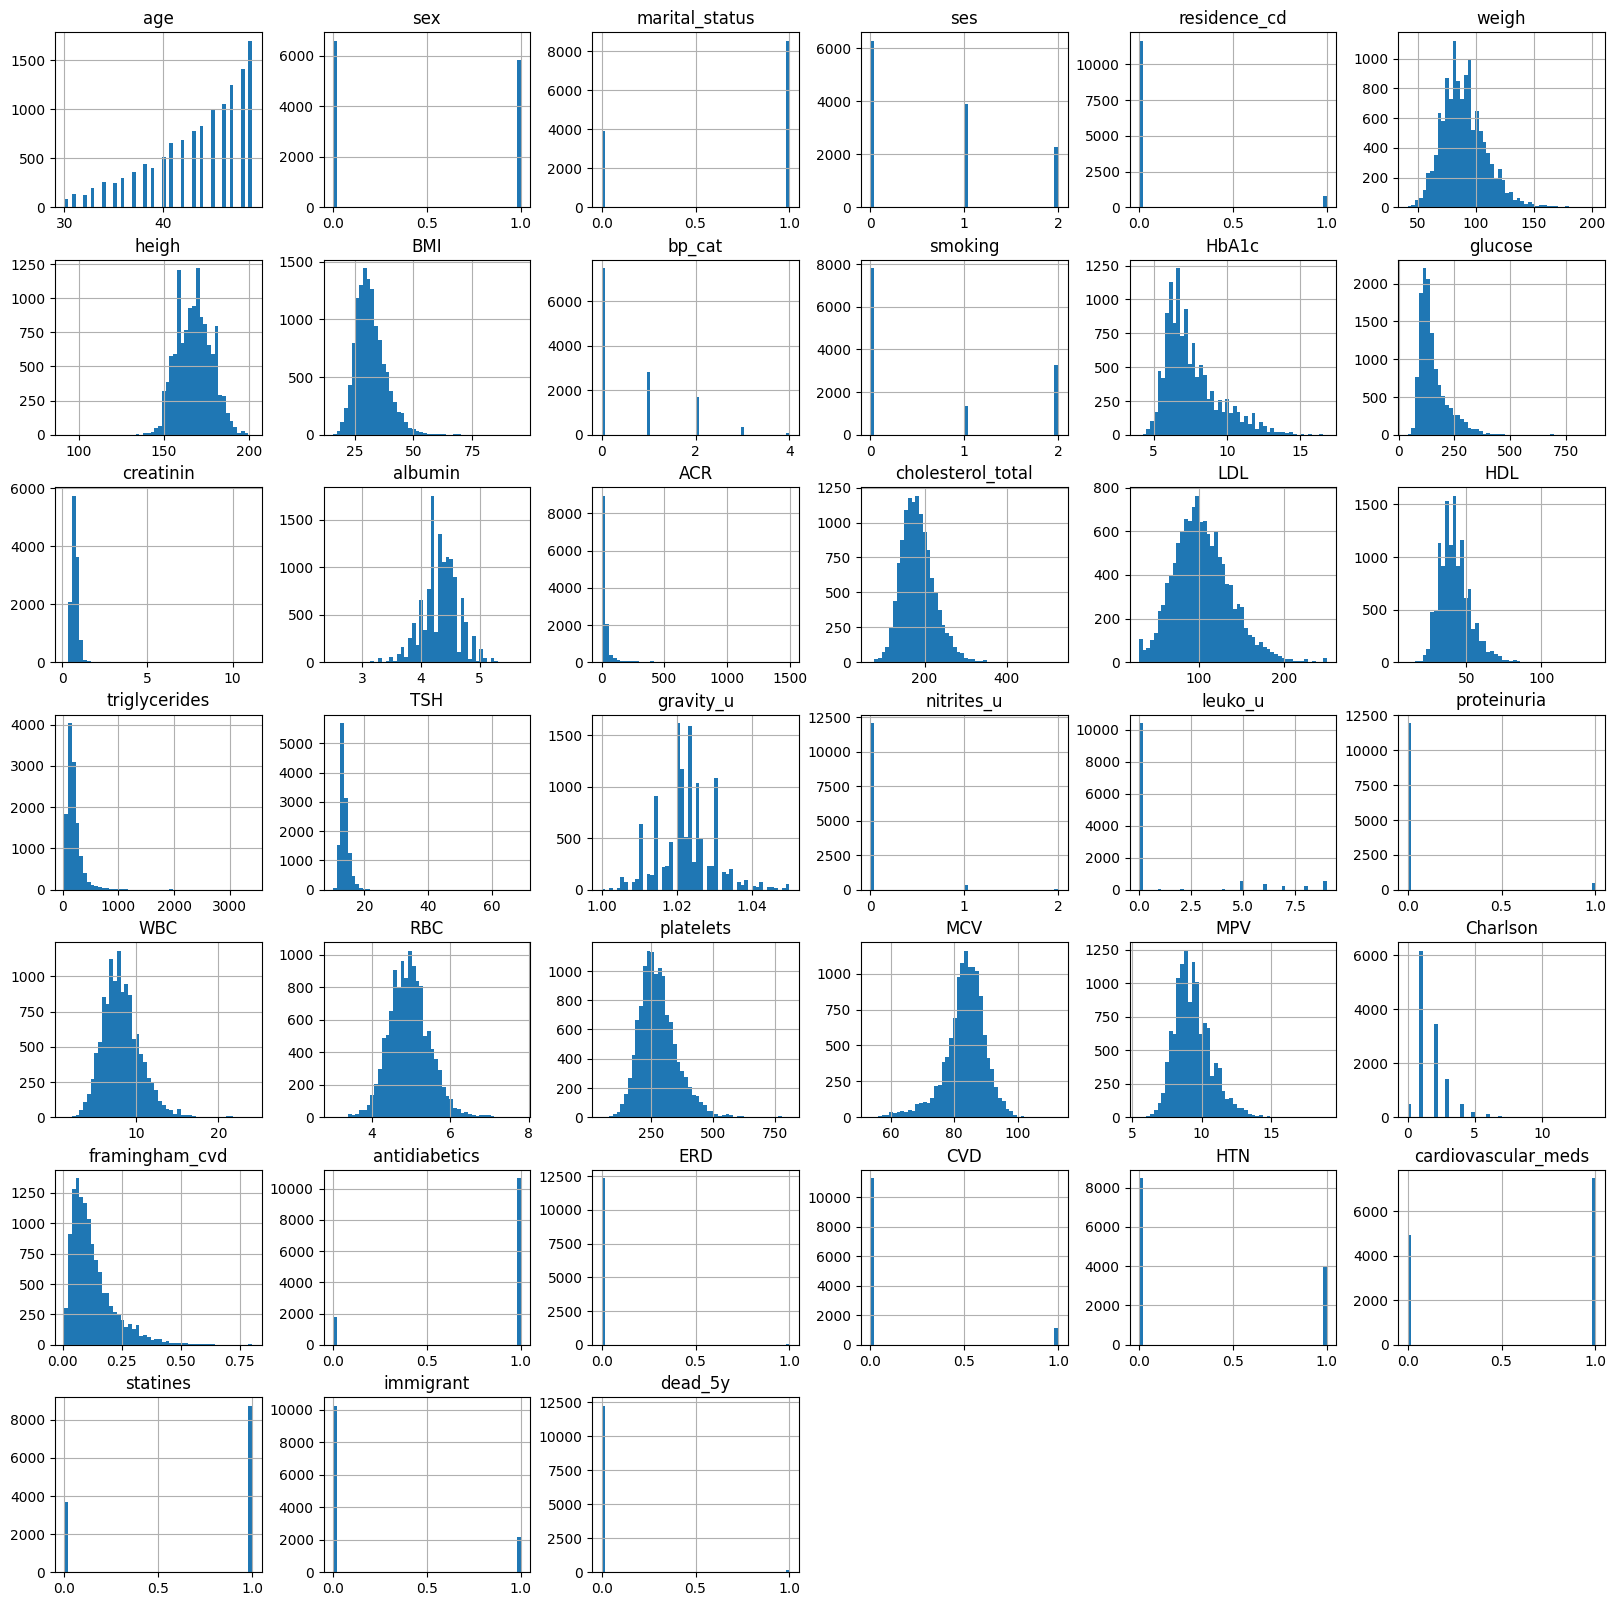

In [76]:
train.hist(bins = 50, figsize=(20,20))

In [30]:
train.head()

,age,sex,marital_status,ses,residence_cd,weigh,heigh,BMI,bp_cat,smoking,HbA1c,glucose,creatinin,albumin,ACR,cholesterol_total,LDL,HDL,triglycerides,TSH,gravity_u,nitrites_u,leuko_u,proteinuria,WBC,RBC,platelets,MCV,MPV,Charlson,framingham_cvd,antidiabetics,ERD,CVD,HTN,cardiovascular_meds,statines,immigrant,dead_5y
0,49,1,0,0,0,84.0,160.0,32.79,0,0,11.0,238,0.58,3.940000,6.00,211.6,114.0,39.0,373,12.5,1.025,0.0,0.0,0.0,10.6,5.11,295,87.9,7.7,1,0.12908,1,0,0,1,1,1,0,0
1,46,1,1,0,0,67.0,152.0,29.38,0,0,7.0,119,0.65,4.500000,3.87,154.0,79.0,41.0,204,13.5,1.021,0.0,0.0,0.0,8.7,4.45,204,78.1,8.2,1,0.08500,1,0,0,0,1,1,0,0
2,46,1,0,0,0,62.4,148.0,28.31,1,0,11.8,202,0.59,4.189946,6.35,252.0,65.0,57.0,272,13.8,1.030,0.0,0.0,0.0,11.5,5.73,772,85.1,10.2,1,0.10715,1,0,0,1,1,1,0,0
3,45,0,0,1,0,73.9,166.0,26.85,0,2,6.9,203,0.70,4.600000,5.00,149.0,92.0,37.0,84,12.6,1.017,0.0,1.0,0.0,9.1,5.06,299,84.6,9.1,1,0.10110,1,0,0,0,0,1,0,0
4,49,1,0,0,0,53.0,161.0,20.45,0,0,8.7,152,0.75,4.400000,0.48,178.0,94.8,57.0,140,11.9,1.028,0.0,0.0,0.0,6.1,4.64,181,89.8,8.9,1,0.03950,1,0,0,0,0,1,0,0


In [42]:
train[['residence','residence_cd']].groupby(["residence"], as_index=False).mean()

,residence,residence_cd
0,rural,2.0
1,urban,1.0


In [43]:
count = train['residence'].value_counts()
count

residence
urban    11659
rural      779
Name: count, dtype: int64

In [44]:
count = train['residence_cd'].value_counts()
count

residence_cd
1    11659
2      779
Name: count, dtype: int64

In [58]:
check = train.loc[train['residence'] == 'urban']
check = check.loc[check['residence_cd'] == 2]
check

KeyError: 'residence'

In [55]:
pd.unique(train['bp_cat'])

array(['Normal', 'Pre-HTN', 'HTN-G2', 'HTN-G1', 'HTN-G3'], dtype=object)

In [117]:
check = train.loc[train['dead_5y'] == 1]
check

,age,sex,marital_status,ses,residence_cd,BMI,bp_cat,smoking,HbA1c,glucose,creatinin,albumin,ACR,cholesterol_total,LDL,HDL,triglycerides,TSH,gravity_u,nitrites_u,leuko_u,proteinuria,WBC,RBC,platelets,MCV,MPV,Charlson,framingham_cvd,antidiabetics,ERD,CVD,HTN,cardiovascular_meds,statines,immigrant,dead_5y
77,43,1,U,1,1,29.73,Normal,3,6.60,130,0.76,4.60,4.00,181.0,88.9,38.0,405,13.2,1.030,0.0,0.0,0.0,12.6,5.21,231,84.9,7.8,2,0.24611,1,0,0,1,1,1,0,1
142,49,1,M,2,1,37.24,HTN-G2,1,4.96,76,4.65,4.00,372.00,154.0,92.8,28.0,216,16.3,1.014,0.0,500.0,1.0,7.5,4.06,460,85.1,7.6,3,0.25291,0,0,0,1,1,0,1,1
153,41,2,M,1,1,19.07,Normal,1,12.50,359,0.56,3.90,13.00,253.0,190.0,60.0,95,16.1,NaN,NaN,NaN,NaN,10.9,4.84,347,72.7,9.3,2,0.04882,1,0,0,0,0,1,0,1
167,48,2,U,1,1,32.05,Normal,1,6.90,89,0.59,4.24,4.00,192.0,79.0,98.0,113,12.9,1.015,0.0,0.0,0.0,6.0,5.45,274,77.2,8.4,2,0.04862,0,0,0,1,1,1,0,1
351,49,1,U,1,1,30.00,HTN-G3,3,7.50,146,0.74,4.52,NaN,161.7,85.0,41.0,185,14.5,1.020,0.0,0.0,0.0,14.4,5.34,247,90.4,14.3,11,0.42287,0,0,0,1,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12153,36,2,M,1,1,21.23,Normal,1,5.59,112,0.55,4.08,1.13,148.0,79.4,52.0,67,14.4,1.020,0.0,0.0,0.0,6.9,4.48,308,70.8,9.2,1,0.01298,0,0,0,0,0,0,0,1
12189,46,1,U,2,1,28.24,Normal,1,6.80,218,0.85,4.60,40.45,227.0,113.0,33.0,397,13.6,NaN,NaN,NaN,NaN,11.5,4.84,424,80.7,10.1,3,0.15443,1,0,0,1,1,1,0,1
12202,43,1,U,3,1,33.31,HTN-G2,3,13.00,444,0.84,4.30,309.82,278.0,235.9,44.0,207,12.8,1.020,0.0,0.0,1.0,8.7,5.20,262,90.0,12.2,2,0.25193,1,0,0,1,1,1,1,1
12245,33,2,U,2,1,39.95,HTN-G1,3,5.43,76,0.67,3.80,979.00,123.0,76.9,39.0,61,15.0,1.010,0.0,4.0,1.0,10.9,5.20,191,75.1,12.8,1,0.13681,0,0,1,0,1,1,0,1


In [118]:
count = train['antidiabetics'].value_counts()
count

antidiabetics
1    10668
0     1770
Name: count, dtype: int64

In [119]:
ERD = train.loc[train['ERD'] == 1]
dead = ERD['dead_5y'].value_counts()
print(f"out of {ERD.shape}, {dead}") # very deadly!

out of (82, 37), dead_5y
0    74
1     8
Name: count, dtype: int64


In [121]:
count = train['CVD'].value_counts()
count

CVD
0    11293
1     1145
Name: count, dtype: int64

In [125]:
CVD = train.loc[train['CVD'] == 1]
dead = CVD['dead_5y'].value_counts()
print(f"out of {CVD.shape[0]}, {dead}") # very deadly!

out of 1145, dead_5y
0    1100
1      45
Name: count, dtype: int64


In [126]:
count = train['HTN'].value_counts()
count

HTN
0    8482
1    3956
Name: count, dtype: int64

In [127]:
HTN = train.loc[train['HTN'] == 1]
dead = HTN['dead_5y'].value_counts()
print(f"out of {HTN.shape[0]}, {dead}") # very deadly!

out of 3956, dead_5y
0    3875
1      81
Name: count, dtype: int64


In [128]:
count = train['cardiovascular_meds'].value_counts()
count

cardiovascular_meds
1    7496
0    4942
Name: count, dtype: int64

In [135]:
CVD = train.loc[train['CVD'] == 1]
CVD = CVD.loc[CVD['cardiovascular_meds'] == 0]
dead = CVD['dead_5y'].value_counts()
print(f"out of {CVD.shape[0]}, {dead}") # very deadly!

out of 173, dead_5y
0    165
1      8
Name: count, dtype: int64


In [136]:
count = train['immigrant'].value_counts()
count

immigrant
0    10263
1     2175
Name: count, dtype: int64

In [23]:
immigrant = train.loc[train['immigrant'] == 1]
dead = immigrant['dead_5y'].value_counts()
print(f"out of {immigrant.shape[0]}, {dead}") # very deadly!

out of 2175, dead_5y
0    2123
1      52
Name: count, dtype: int64


In [43]:
for i in range(6):
    BMI = train.loc[train['BMI'] == i]
    dead = BMI['dead_5y'].value_counts()
    print(f"for BMI of {i} \nout of {BMI.shape[0]} people, {dead[1]} died\nthe ratio of people to dead people in this catagory is {dead[1]/BMI.shape[0]}\n\n")

for BMI of 0 
out of 27 people, 1 died
the ratio of people to dead people in this catagory is 0.037037037037037035


for BMI of 1 
out of 1394 people, 36 died
the ratio of people to dead people in this catagory is 0.02582496413199426


for BMI of 2 
out of 3947 people, 49 died
the ratio of people to dead people in this catagory is 0.01241449201925513


for BMI of 3 
out of 5781 people, 77 died
the ratio of people to dead people in this catagory is 0.013319494897076631


for BMI of 4 
out of 1139 people, 26 died
the ratio of people to dead people in this catagory is 0.0228270412642669


for BMI of 5 
out of 150 people, 8 died
the ratio of people to dead people in this catagory is 0.05333333333333334




In [33]:
count = train['dead_5y'].value_counts()
count

dead_5y
0    12241
1      197
Name: count, dtype: int64

In [274]:
ses = train.loc[train['ses'] == 0]
dead = ses['dead_5y'].value_counts()
print(f"out of {ses.shape[0]}, {dead}") # very deadly!

out of 6281, dead_5y
0    6200
1      81
Name: count, dtype: int64


In [275]:
ses = train.loc[train['ses'] == 2]
dead = ses['dead_5y'].value_counts()
print(f"out of {ses.shape[0]}, {dead}") # very deadly!

out of 2267, dead_5y
0    2222
1      45
Name: count, dtype: int64
